In [ ]:
%pylab inline
import numpy as np
from tqdm import trange
np.set_printoptions(suppress=False)
import torch
import torch.nn  as nn
import torch.nn.functional as F
torch.set_printoptions(sci_mode=False)
from tqdm import tqdm
import math

Populating the interactive namespace from numpy and matplotlib


In [ ]:
def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [ ]:
class net(torch.nn.Module):
  def __init__(self):
    super(net, self).__init__()
    self.l1 = nn.Linear(784, 128, bias=False)
    self.l2 = nn.Linear(128, 10, bias=False)
    self.sm = nn.LogSoftmax(dim=1)
  def forward(self, x):
    x = F.relu(self.l1(x))
    x = self.l2(x)
    x = self.sm(x)
    return x

In [ ]:
model = net()
model 

net(
  (l1): Linear(in_features=784, out_features=128, bias=False)
  (l2): Linear(in_features=128, out_features=10, bias=False)
  (sm): LogSoftmax(dim=1)
)

In [ ]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

 0 loss :29.909 ,accuracy : 0.070
 100 loss :0.390 ,accuracy : 0.875
 200 loss :0.411 ,accuracy : 0.906
 300 loss :0.151 ,accuracy : 0.961
 400 loss :0.594 ,accuracy : 0.891
 500 loss :0.289 ,accuracy : 0.875
 600 loss :0.239 ,accuracy : 0.930
 700 loss :0.187 ,accuracy : 0.945
 800 loss :0.172 ,accuracy : 0.953
 900 loss :0.098 ,accuracy : 0.969


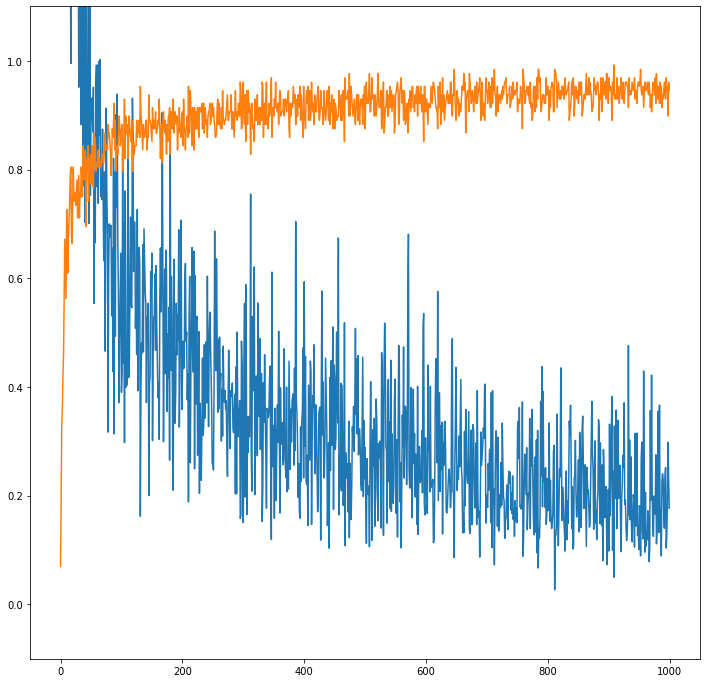

In [ ]:
loss_function = nn.NLLLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
BS = 128
losses, accuracies = [], []
for i in range(1000):
    samp = np.random.randint(0,X_train.shape[0], size = BS)
    X = torch.tensor(X_train[samp].reshape((-1,28*28))).float()
    Y = torch.tensor(Y_train[samp]).long()
    
    model.zero_grad()
    out = model(X)
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    
    loss = loss_function(out, Y)
    loss = loss.mean()
    
    loss.backward()
    optim.step()
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    if i % 100 == 0:
        print(f""" {i} loss :{'%.3f' % loss} ,accuracy : {'%.3f' % accuracy}""")
figure(figsize = (12,12))
plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)

In [ ]:
Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()

In [ ]:
(Y_test == Y_test_preds).mean()

0.9315

In [ ]:
l1 = np.zeros((784,128), dtype = np.float32)
l2 = np.zeros((128,10), dtype = np.float32)
l1[:] = model.l1.weight.detach().numpy().T
l2[:] = model.l2.weight.detach().numpy().T

In [ ]:
l1.shape, l2.shape

((784, 128), (128, 10))

In [ ]:

def forward(x):
    x = x.dot(l1)
    x = np.maximum(0,x)
    x = x.dot(l2)
    return x
Y_test_preds_out = forward(X_test.reshape((-1,28*28)))
Y_test_preds = np.argmax(Y_test_preds_out,axis =  1)
(Y_test == Y_test_preds).mean()

0.9315

In [ ]:
# NLL Loss
ce = - Y_test_preds_out[range(Y_test_preds_out.shape[0]), Y_test] + np.log(np.exp(Y_test_preds_out).sum(axis = 1))

In [ ]:
ce

array([8.0108643e-05, 7.5059891e-02, 1.0204315e-04, ..., 0.0000000e+00,
       1.3923645e-04, 0.0000000e+00], dtype=float32)

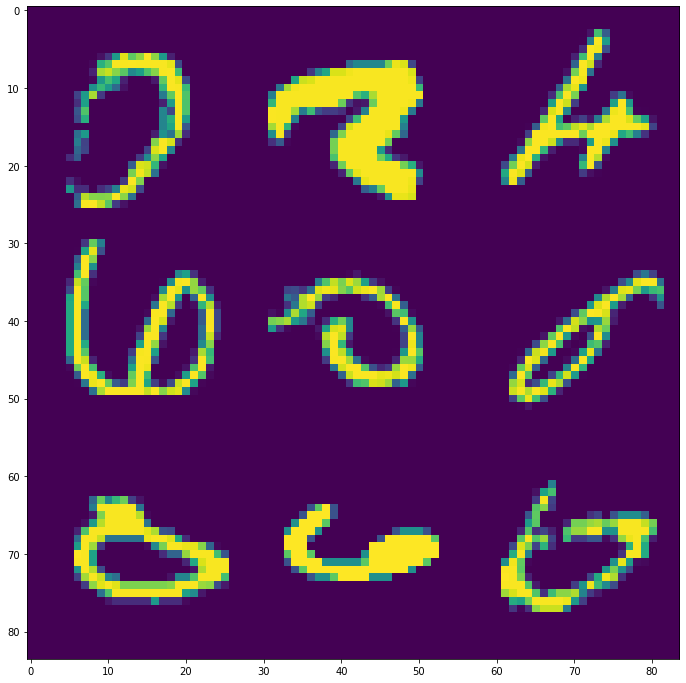

In [ ]:
grid = sorted(list(zip(ce, range(ce.shape[0]))), reverse = True)[:9]
bad = X_test[[j for i,j in grid]]
bad = bad.reshape((3,3*28,28))
plt.figure(figsize = (12,12))
plt.imshow(np.concatenate(bad, axis = 1))

(tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.5000,
           0.0000,  0.0000],
         [ 0.0000,  0.0000, -0.5000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000]]), tensor(1.))

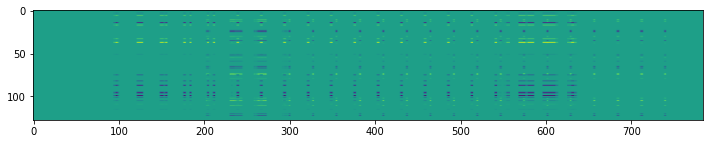

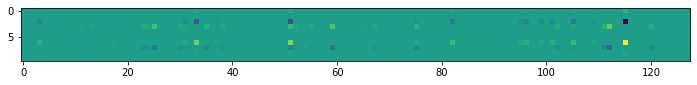

In [ ]:
samp = [0,1]
model.zero_grad()
out = model(torch.tensor(X_test[samp].reshape(-1,28*28)).float())
out.retain_grad()
loss = loss_function(out, torch.tensor(Y_test[samp]).long()).mean()
loss.retain_grad()
loss.backward()
figure(figsize = (12,12))
plt.imshow(model.l1.weight.grad)
figure(figsize = (12,12))
plt.imshow(model.l2.weight.grad)
out.grad, loss.grad

In [ ]:

samp = [0,1,2,3]
x, y = X_test[samp].reshape((-1, 28*28)), Y_test[samp]
out = np.zeros((len(y),10), dtype = np.float32)
out[range(out.shape[0]), y] = 1

#forward pass
#l1
x_l1 = x.dot(l1)
x_relu = np.maximum(x_l1, 0)
#l2
logits = x_relu.dot(l2)
#softmax
counts = np.exp(logits)
prob = counts/ counts.sum(1, keepdims = True)
# NLL Loss
x_loss = -np.mean(np.log(prob[range(len(y)), y]))

In [ ]:
#checking with torch
x_loss , F.cross_entropy(torch.tensor(logits), torch.tensor(y))

(0.0007464635200680465, tensor(0.0007, dtype=torch.float64))

In [ ]:
samp = [0,1,2,3]
x, y = X_test[samp].reshape((-1, 28*28)), Y_test[samp]
out = np.zeros((len(y),10), dtype = np.float32)
out[range(out.shape[0]), y] = 1

#forward pass
#l1
x_l1 = x.dot(l1)
x_relu = np.maximum(x_l1, 0)
#l2
logits = x_relu.dot(l2)
#softmax
counts = np.exp(logits)
prob = counts/ counts.sum(1, keepdims = True)
# NLL Loss
x_loss = -np.mean(np.log(prob[range(len(y)), y]))

In [ ]:
Y_test_preds_out = forward(X_test.reshape((-1, 28*28)))
Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
(Y_test == Y_test_preds).mean()

0.0932